## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 5000                                       # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2023-07-09 21:08:13.276039


{1: 23.4,
 5: 24.7,
 10: 25.4,
 20: 26.3,
 30: 27.1,
 40: 27.9,
 50: 29.4,
 60: 31.1,
 70: 33.1,
 80: 35.5,
 90: 38.9,
 95: 41.7,
 99: 47.301000000000016}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

Cache from: 2023-09-08 13:39:24.951746


{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.5}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2023-09-05 17:35:37.520277


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=4.37, lognorm_sd=1.93, norm_mean=1.39, norm_sd=0.42)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=9.15, lognorm_sd=5.75, norm_mean=2.05, norm_sd=0.58)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=12.12, lognorm_sd=9.64, norm_mean=2.25, norm_sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lo

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.lognorm(18, 19.2),
             'flop_halving_rate': sq.lognorm(1.4, 4.1),     # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 8.5, lclip=0.9),
             '2025_spend_doubling_time': sq.norm(0.94, 1.02, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1101098.39it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00032,
 50: 0.0004,
 60: 0.00053,
 70: 0.00069,
 80: 0.00103,
 90: 0.00216,
 95: 0.00382,
 99: 0.00977}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6 billion',
 5: '6 billion',
 10: '6 billion',
 20: '6 billion',
 30: '6 billion',
 40: '7 billion',
 50: '9 billion',
 60: '12 billion',
 70: '16 billion',
 80: '24 billion',
 90: '50 billion',
 95: '88 billion',
 99: '225 billion'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 40.8 log FLOP (~63 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.0 log FLOP (~1 quintillion) per 2022$USD. Every 1.5 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~475 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.039137% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.034x per year.
---
Year: 2023 - 26.7 max log FLOP (472 septillion) available - TAI takes 40.8 log FLOP (63 million decillion) - log $ 22.8 to buy TAI (60 sextillion) vs. willingness to pay log $ 8.7 (451 million) - 18.0 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 40.5 log FLOP (32 million decillion) - log $ 22.3 to buy TAI (19 sextillion) vs. wil

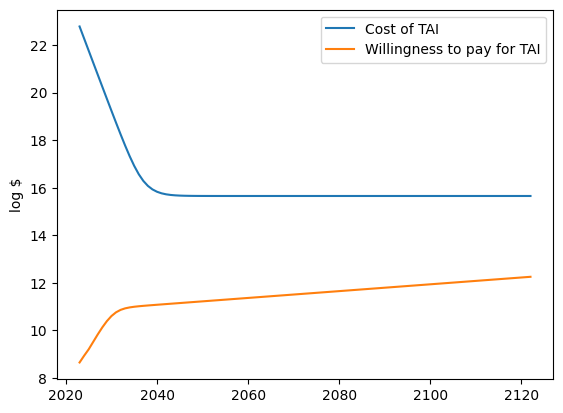

-
-
## SAMPLE RUN 2 ##
It takes 25.5 log FLOP (~32 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.3 log FLOP (~21 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 1.1 years to a max of 0.02727% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 28.3 max log FLOP (22 octillion) available - TAI takes 25.5 log FLOP (32 septillion) - log $ 6.2 to buy TAI (2 million) vs. willingness to pay log $ 9.0 (1 billion) - 19.3 log FLOP per $ (21 quintillion) (Effective 2023-logFLOP: 28.3)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 

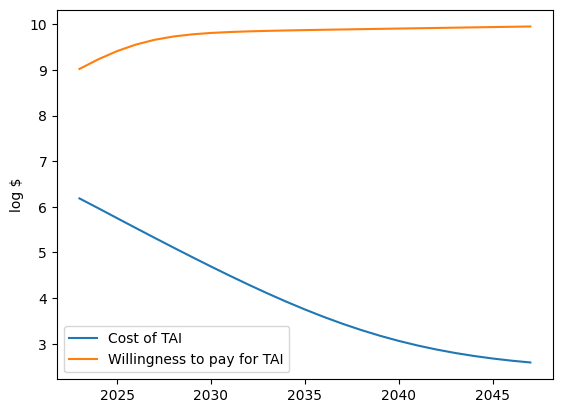

-
-
## SAMPLE RUN 3 ##
It takes 37.7 log FLOP (~50 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 1.4 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~26 septillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 1.5 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 37.7 log FLOP (50 thousand decillion) - log $ 19.2 to buy TAI (17 quintillion) vs. willingness to pay log $ 8.9 (876 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 37.4 log FLOP (25 thousand decillion) - log $ 18.7 to buy TAI (5 quintillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.7 lo

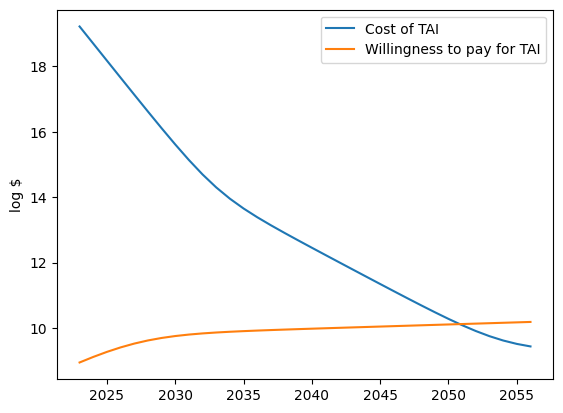

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 289.04it/s]


Shuffling data...
Writing data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 314.46it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2030',
 '10%: 2032',
 '15%: 2034',
 '20%: 2035',
 '25%: 2036',
 '35%: 2039',
 '50%: 2043',
 '60%: 2047',
 '75%: 2061',
 '80%: 2068',
 '90%: >2123',
 '95%: >2123']
(Mean: 2055)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 7 years from now',
 '10%: 9 years from now',
 '15%: 11 years from now',
 '20%: 12 years from now',
 '25%: 13 years from now',
 '35%: 16 years from now',
 '50%: 20 years from now',
 '60%: 24 years from now',
 '75%: 38 years from now',
 '80%: 45 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 32 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.1%
2028-2029: 3.2%
2030-2034: 15.0%
2035-2039: 20.0%
2040-2049: 26.0%
2050-2059: 9.6%
2060-2069: 6.9%
2070-2079: 3.4%
2080-2089: 2.3%
2090-2099: 1.1%
2100-2109: 0.6%

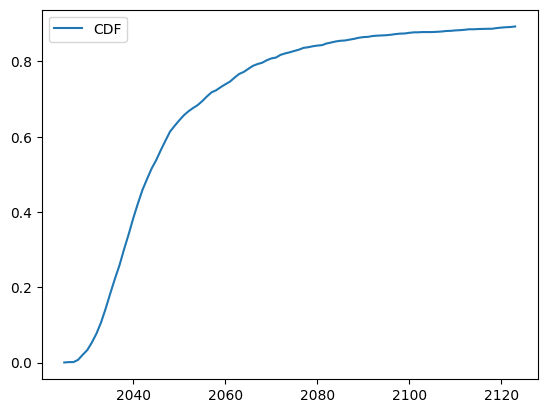

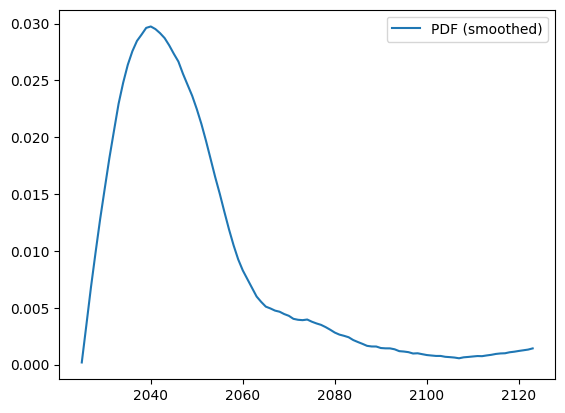

-
-
## TAI FLOP SIZE ##
{1: 23.4,
 5: 24.7,
 10: 25.4,
 20: 26.4,
 30: 27.2,
 40: 28.2,
 50: 29.9,
 60: 31.4,
 70: 33.3,
 80: 35.5,
 90: 39.2,
 95: 42.1,
 99: 46.1}
(Mean: 31.0)


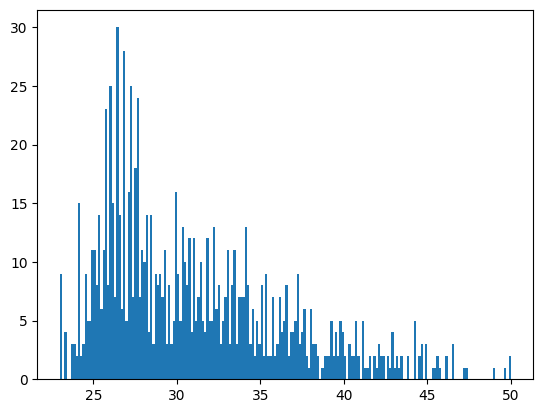

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 21.0,
 5: 15.4,
 10: 12.7,
 20: 10.3,
 30: 8.6,
 40: 7.5,
 50: 6.7,
 60: 6.0,
 70: 5.2,
 80: 4.4,
 90: 3.5,
 95: 2.9,
 99: 2.1}
(Mean: 7.6)


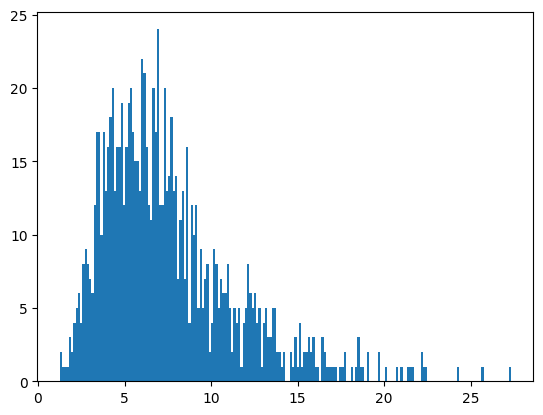

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR ##
{1: 17.7,
 5: 18.0,
 10: 18.1,
 20: 18.3,
 30: 18.4,
 40: 18.5,
 50: 18.6,
 60: 18.7,
 70: 18.8,
 80: 18.9,
 90: 19.1,
 95: 19.2,
 99: 19.4}
(Mean: 18.6)


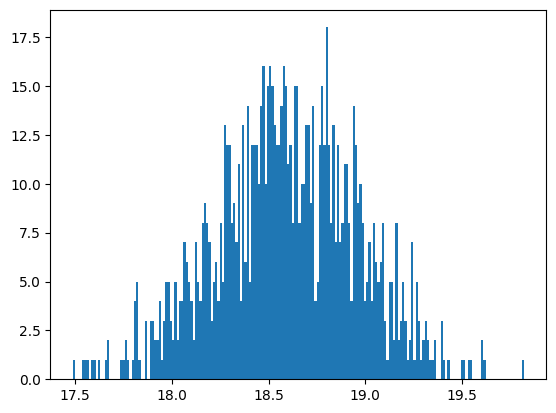

-
-
## FLOP HALVING RATE ##
{1: 5.1,
 5: 4.1,
 10: 3.6,
 20: 3.2,
 30: 2.8,
 40: 2.6,
 50: 2.4,
 60: 2.2,
 70: 2.0,
 80: 1.8,
 90: 1.5,
 95: 1.3,
 99: 1.1}
(Mean: 2.5)


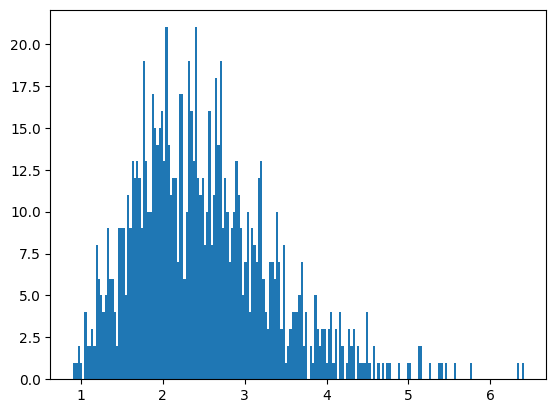

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.1,
 5: 21.0,
 10: 21.4,
 20: 22.2,
 30: 22.6,
 40: 23.0,
 50: 23.3,
 60: 23.7,
 70: 24.1,
 80: 24.6,
 90: 25.4,
 95: 26.0,
 99: 27.4}
(Mean: 23.4)


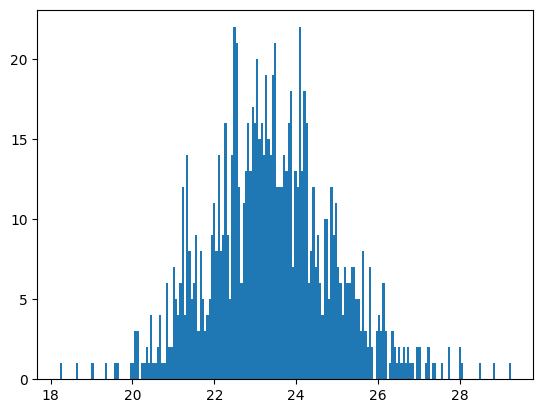

-
-
## INITIAL PAY ##
{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.6}
(Mean: 8.7)


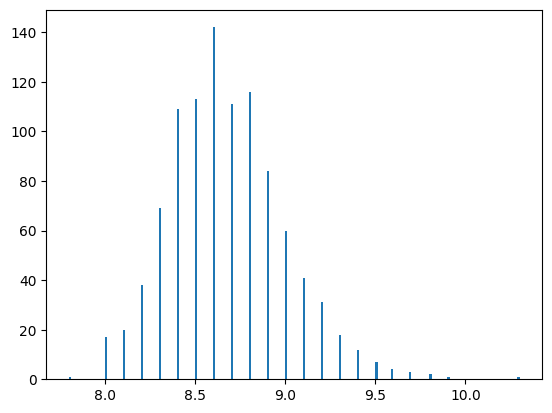

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}
(Mean: 1.0)


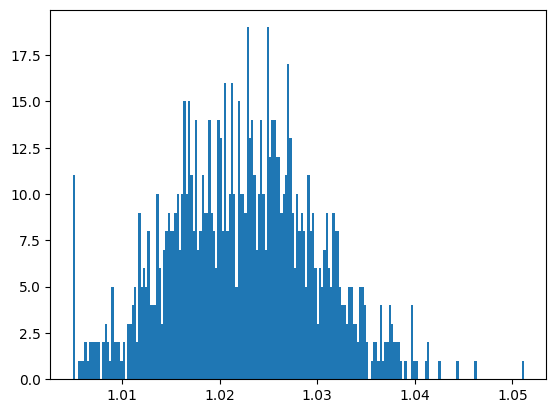

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.0004,
 60: 0.00051,
 70: 0.00067,
 80: 0.00101,
 90: 0.00197,
 95: 0.00406,
 99: 0.00873}
(Mean: 0.0)


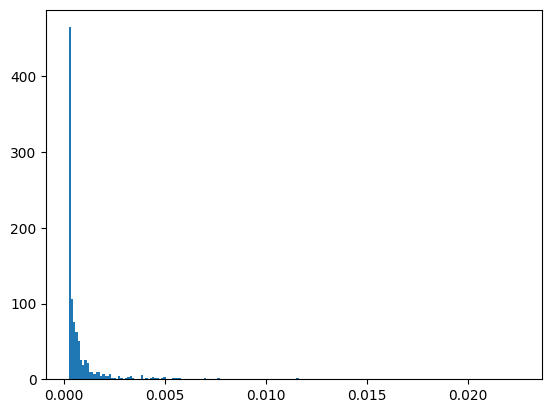

-
-
## SPEND DOUBLING TIME ##
{1: 14.1,
 5: 8.8,
 10: 6.9,
 20: 5.1,
 30: 4.1,
 40: 3.5,
 50: 2.9,
 60: 2.5,
 70: 2.1,
 80: 1.7,
 90: 1.2,
 95: 0.9,
 99: 0.9}
(Mean: 3.7)


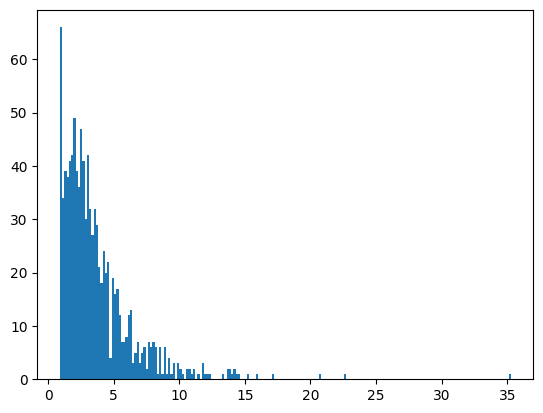

-
-
-
-
## GDP Over Time ##


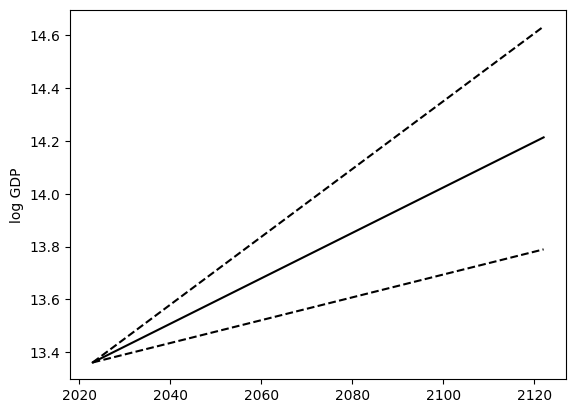

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

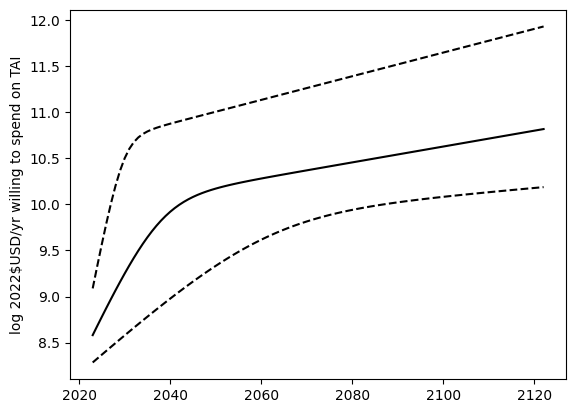

Year: 2023 - willingness log 2022$USD per year 8.6 (~382 million) 90% CI 8.3 (~193 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.7 (~480 million) 90% CI 8.3 (~213 million) - 9.3 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.8 (~602 million) 90% CI 8.4 (~234 million) - 9.6 (~4 billion)
Year: 2026 - willingness log 2022$USD per year 8.9 (~753 million) 90% CI 8.4 (~258 million) - 9.8 (~6 billion)
Year: 2027 - willingness log 2022$USD per year 9.0 (~938 million) 90% CI 8.5 (~284 million) - 10.0 (~10 billion)
Year: 2028 - willingness log 2022$USD per year 9.1 (~1 billion) 90% CI 8.5 (~313 million) - 10.2 (~16 billion)
Year: 2029 - willingness log 2022$USD per year 9.2 (~1 billion) 90% CI 8.5 (~344 million) - 10.4 (~23 billion)
Year: 2030 - willingness log 2022$USD per year 9.2 (~2 billion) 90% CI 8.6 (~378 million) - 10.5 (~31 billion)
Year: 2031 - willingness log 2022$USD per year 9.3 (~2 billion) 90% CI 8.6 (~416 million) - 10.6 (~40 billion)

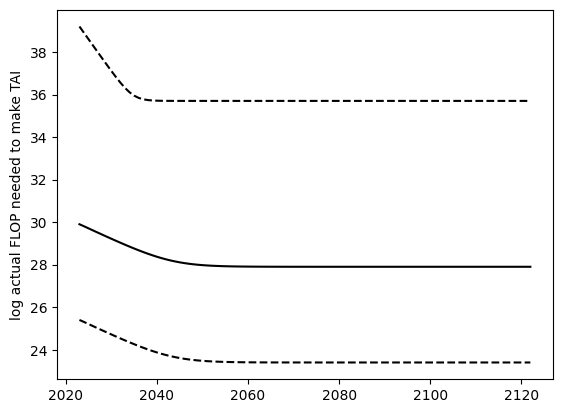

Year: 2023 - log FLOP needed for TAI 29.9 (~794 octillion) 90% CI 25.4 (~25 septillion) - 39.2 (~2 million decillion)
Year: 2024 - log FLOP needed for TAI 29.8 (~638 octillion) 90% CI 25.3 (~20 septillion) - 38.9 (~793 thousand decillion)
Year: 2025 - log FLOP needed for TAI 29.7 (~508 octillion) 90% CI 25.2 (~16 septillion) - 38.6 (~397 thousand decillion)
Year: 2026 - log FLOP needed for TAI 29.6 (~405 octillion) 90% CI 25.1 (~13 septillion) - 38.3 (~199 thousand decillion)
Year: 2027 - log FLOP needed for TAI 29.5 (~323 octillion) 90% CI 25.0 (~10 septillion) - 38.0 (~100 thousand decillion)
Year: 2028 - log FLOP needed for TAI 29.4 (~258 octillion) 90% CI 24.9 (~8 septillion) - 37.7 (~50 thousand decillion)
Year: 2029 - log FLOP needed for TAI 29.3 (~207 octillion) 90% CI 24.8 (~7 septillion) - 37.4 (~25 thousand decillion)
Year: 2030 - log FLOP needed for TAI 29.2 (~166 octillion) 90% CI 24.7 (~5 septillion) - 37.1 (~13 thousand decillion)
Year: 2031 - log FLOP needed for TAI 29.1

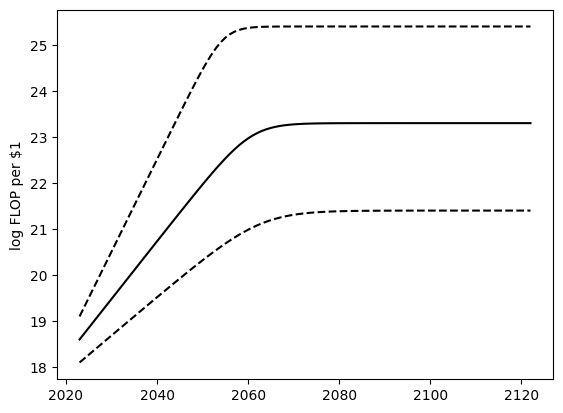

Year: 2023 - log FLOP per 2022$1USD 18.6 (~4 quintillion) 90% CI 18.1 (~1 quintillion) - 19.1 (~13 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.2 (~2 quintillion) - 19.3 (~20 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.9 (~7 quintillion) 90% CI 18.3 (~2 quintillion) - 19.5 (~32 quintillion)
Year: 2026 - log FLOP per 2022$1USD 19.0 (~9 quintillion) 90% CI 18.4 (~2 quintillion) - 19.7 (~50 quintillion)
Year: 2027 - log FLOP per 2022$1USD 19.1 (~13 quintillion) 90% CI 18.4 (~3 quintillion) - 19.9 (~80 quintillion)
Year: 2028 - log FLOP per 2022$1USD 19.2 (~17 quintillion) 90% CI 18.5 (~3 quintillion) - 20.1 (~127 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.4 (~23 quintillion) 90% CI 18.6 (~4 quintillion) - 20.3 (~201 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.5 (~30 quintillion) 90% CI 18.7 (~5 quintillion) - 20.5 (~320 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.6 (~40 quintillion) 90% CI 18.8 (~6 quintillion) - 20.7 (~

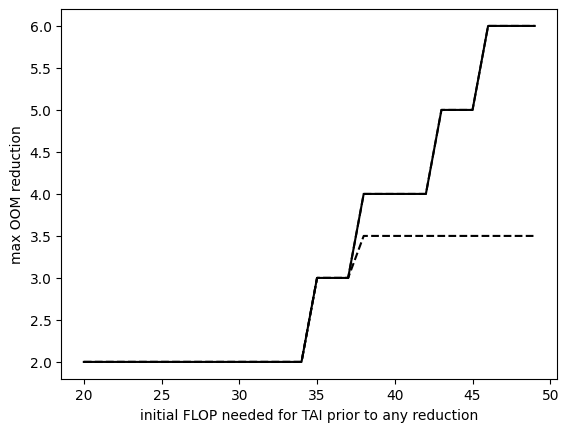

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

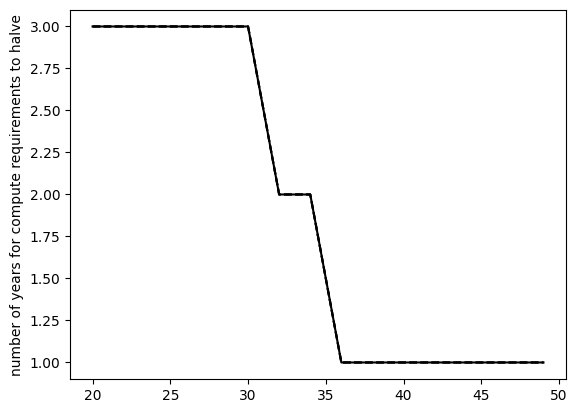

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

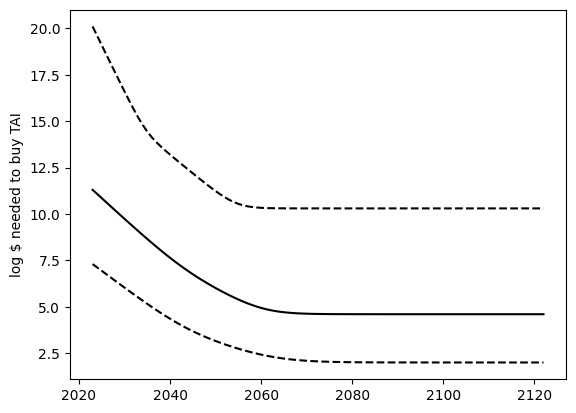

Year: 2023 - 11.3 log 2022$USD to buy TAI (~200 billion) 90% CI 7.3 (~20 million) - 20.1 (~126 quintillion)
Year: 2024 - 11.1 log 2022$USD to buy TAI (~120 billion) 90% CI 7.1 (~13 million) - 19.6 (~40 quintillion)
Year: 2025 - 10.9 log 2022$USD to buy TAI (~72 billion) 90% CI 6.9 (~9 million) - 19.1 (~13 quintillion)
Year: 2026 - 10.6 log 2022$USD to buy TAI (~43 billion) 90% CI 6.8 (~6 million) - 18.6 (~4 quintillion)
Year: 2027 - 10.4 log 2022$USD to buy TAI (~26 billion) 90% CI 6.6 (~4 million) - 18.1 (~1 quintillion)
Year: 2028 - 10.2 log 2022$USD to buy TAI (~15 billion) 90% CI 6.4 (~2 million) - 17.6 (~394 quadrillion)
Year: 2029 - 10.0 log 2022$USD to buy TAI (~9 billion) 90% CI 6.2 (~2 million) - 17.1 (~125 quadrillion)
Year: 2030 - 9.7 log 2022$USD to buy TAI (~6 billion) 90% CI 6.0 (~1 million) - 16.6 (~40 quadrillion)
Year: 2031 - 9.5 log 2022$USD to buy TAI (~3 billion) 90% CI 5.9 (~718 thousand) - 16.1 (~13 quadrillion)
Year: 2032 - 9.3 log 2022$USD to buy TAI (~2 billion

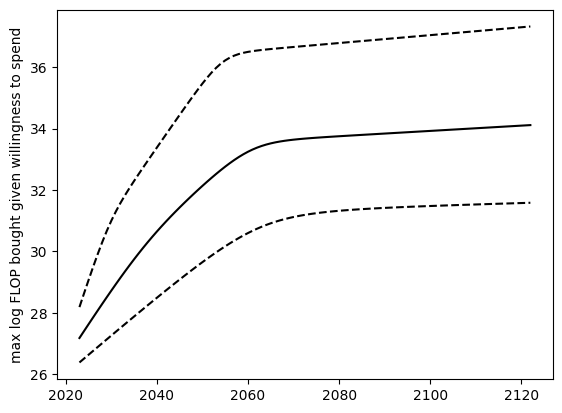

Year: 2023 - max log FLOP 27.2 (~2 octillion) 90% CI 26.4 (~243 septillion) - 28.2 (~15 octillion)
Year: 2024 - max log FLOP 27.4 (~3 octillion) 90% CI 26.5 (~324 septillion) - 28.6 (~43 octillion)
Year: 2025 - max log FLOP 27.6 (~4 octillion) 90% CI 26.6 (~433 septillion) - 29.1 (~117 octillion)
Year: 2026 - max log FLOP 27.9 (~7 octillion) 90% CI 26.8 (~578 septillion) - 29.5 (~314 octillion)
Year: 2027 - max log FLOP 28.1 (~12 octillion) 90% CI 26.9 (~772 septillion) - 29.9 (~812 octillion)
Year: 2028 - max log FLOP 28.3 (~20 octillion) 90% CI 27.0 (~1 octillion) - 30.3 (~2 nonillion)
Year: 2029 - max log FLOP 28.5 (~32 octillion) 90% CI 27.1 (~1 octillion) - 30.7 (~5 nonillion)
Year: 2030 - max log FLOP 28.7 (~53 octillion) 90% CI 27.3 (~2 octillion) - 31.0 (~10 nonillion)
Year: 2031 - max log FLOP 28.9 (~86 octillion) 90% CI 27.4 (~2 octillion) - 31.3 (~20 nonillion)
Year: 2032 - max log FLOP 29.1 (~140 octillion) 90% CI 27.5 (~3 octillion) - 31.6 (~38 nonillion)
Year: 2033 - max 

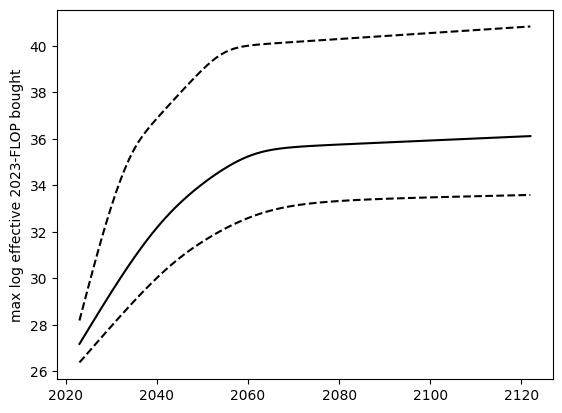

Year: 2023 - max log effective 2023-FLOP 27.2 (~2 octillion) 90% CI 26.4 (~243 septillion) - 28.2 (~15 octillion)
Year: 2024 - max log effective 2023-FLOP 27.5 (~3 octillion) 90% CI 26.6 (~403 septillion) - 28.9 (~85 octillion)
Year: 2025 - max log effective 2023-FLOP 27.8 (~7 octillion) 90% CI 26.8 (~677 septillion) - 29.7 (~468 octillion)
Year: 2026 - max log effective 2023-FLOP 28.1 (~14 octillion) 90% CI 27.1 (~1 octillion) - 30.4 (~3 nonillion)
Year: 2027 - max log effective 2023-FLOP 28.5 (~29 octillion) 90% CI 27.3 (~2 octillion) - 31.1 (~13 nonillion)
Year: 2028 - max log effective 2023-FLOP 28.8 (~60 octillion) 90% CI 27.5 (~3 octillion) - 31.8 (~64 nonillion)
Year: 2029 - max log effective 2023-FLOP 29.1 (~125 octillion) 90% CI 27.7 (~5 octillion) - 32.5 (~292 nonillion)
Year: 2030 - max log effective 2023-FLOP 29.4 (~255 octillion) 90% CI 27.9 (~9 octillion) - 33.1 (~1 decillion)
Year: 2031 - max log effective 2023-FLOP 29.7 (~516 octillion) 90% CI 28.2 (~15 octillion) - 33.

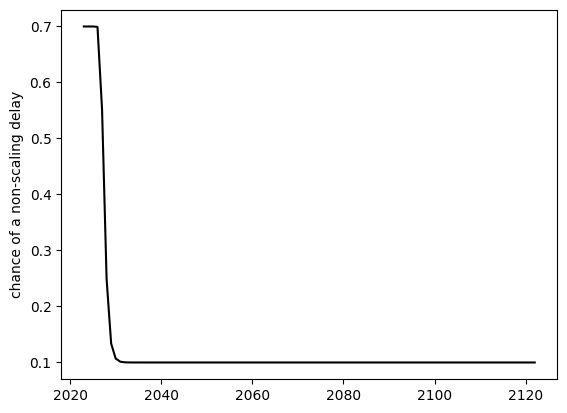

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 55%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

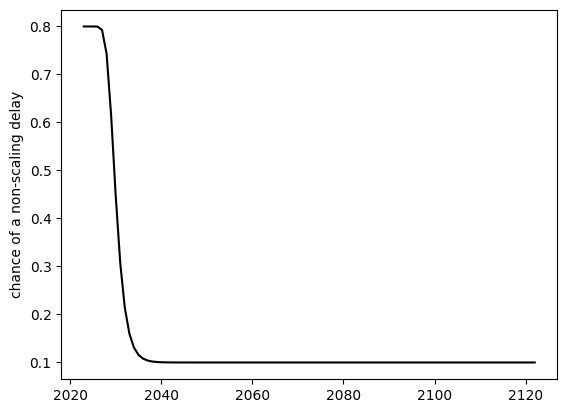

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 79%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 74%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 61%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 45%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 31%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2033

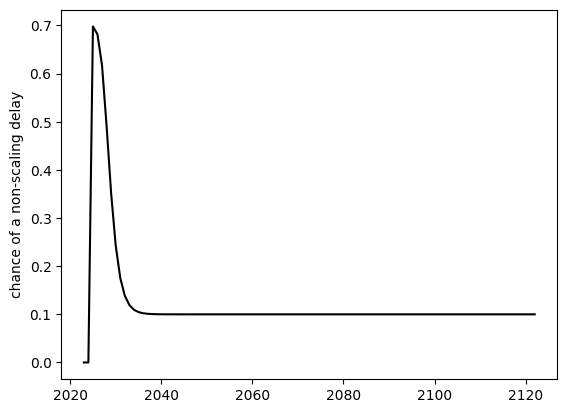

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 68%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 62%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 49%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 35%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2033 -

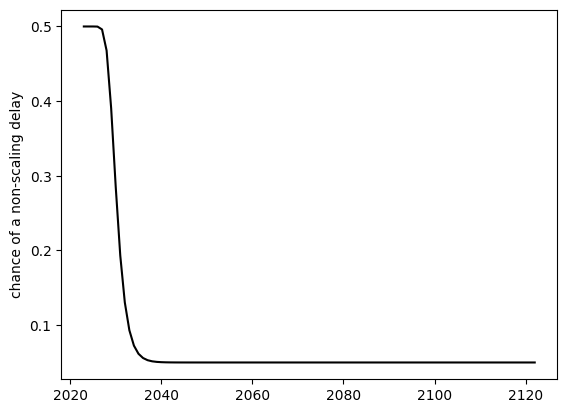

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 47%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2033

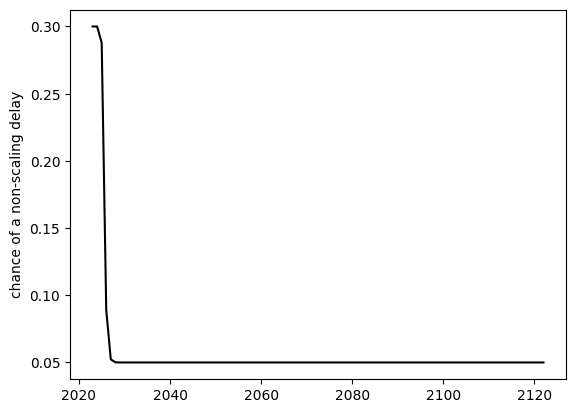

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chan

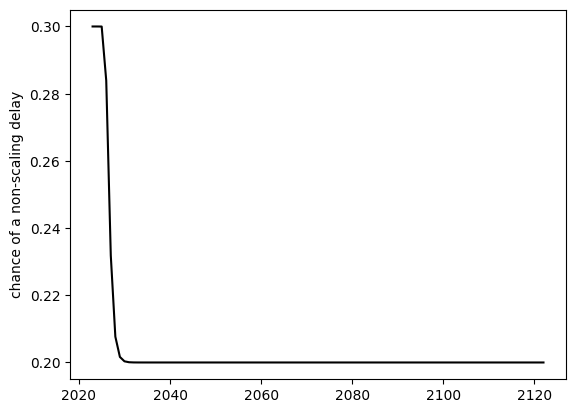

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2033

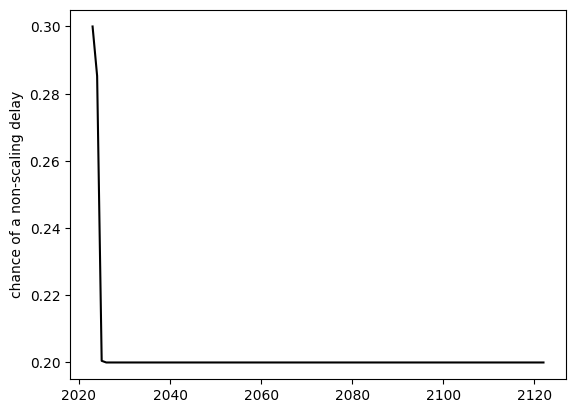

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2033

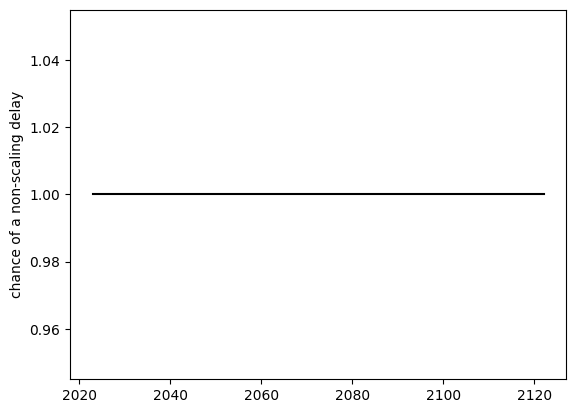

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%


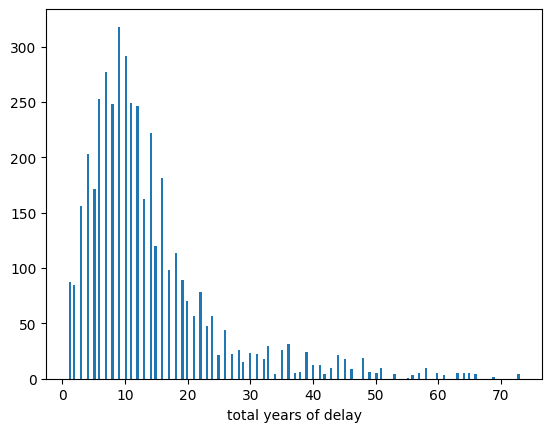

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 32.1 log FLOP (~126 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~10 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~783 million). This doubles every 3.2 years to a max of 0.23222% of GDP (initially ~53 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.9 max log FLOP (8 octillion) available - TAI takes 32.1 log FLOP (126 nonillion) - log $ 13.1 to buy TAI (12 trillion) vs. willingness to pay log $ 8.9 (771 million) - 19.0 log FLOP per $ (10 quintillion) (Effective 2023-logFLOP: 27.9)
Year: 2024 - 28.2 max log FLOP (14 octillion) available - TAI takes 32.0 log FLOP (90 nonillion) - log $ 12.8 to buy TAI (6 trillion) vs. willingness to pay log $ 9.0 (955 million) - 19.2 log FLOP per $ (15 qui

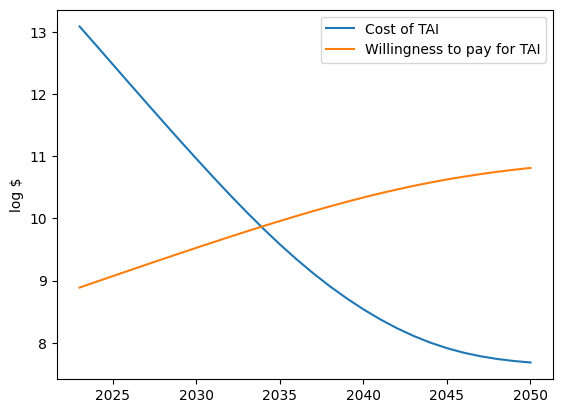

-
-
## SAMPLE RUN 5 ##
It takes 45.5 log FLOP (~3 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~18 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~1 billion). This doubles every 3.6 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 45.5 log FLOP (3 trillion decillion) - log $ 27.1 to buy TAI (1 octillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 45.2 log FLOP (2 trillion decillion) - log $ 26.7 to buy TAI (492 septillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.5 log FLOP p

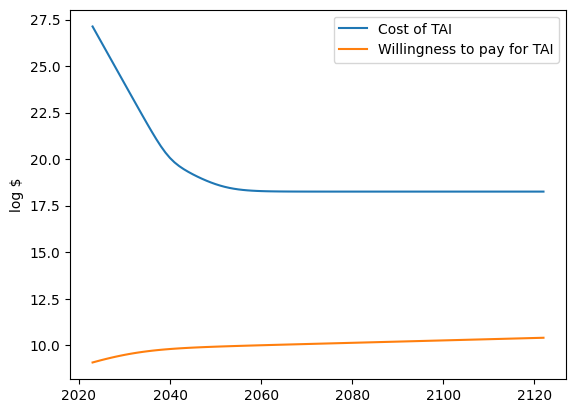

-
-
## SAMPLE RUN 6 ##
It takes 38.2 log FLOP (~158 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~235 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~389 million). This doubles every 2.2 years to a max of 0.077829% of GDP (initially ~18 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 38.2 log FLOP (158 thousand decillion) - log $ 19.7 to buy TAI (54 quintillion) vs. willingness to pay log $ 8.6 (381 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 37.9 log FLOP (79 thousand decillion) - log $ 19.3 to buy TAI (20 quintillion) vs. willingness to pay log $ 8.7 (519 million

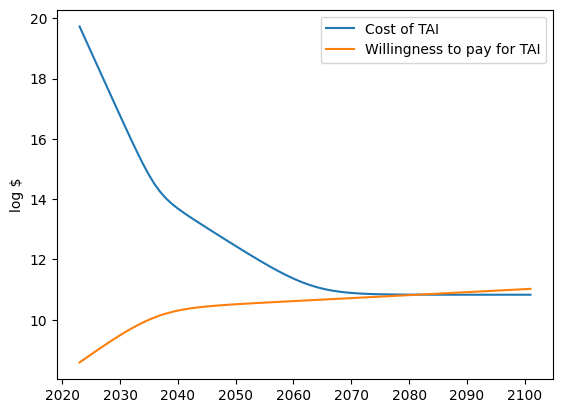

-
-
## SAMPLE RUN 7 ##
It takes 30.5 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~9 quintillion) per 2022$USD. Every 4.2 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~45 septillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 1.5 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 11.6 to buy TAI (356 billion) vs. willingness to pay log $ 8.2 (150 million) - 18.9 log FLOP per $ (9 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 30.4 log FLOP (2 nonillion) - log $ 11.4 to buy TAI (232 billion) vs. willingness to pay log $ 8.4 (236 million) - 19.0 log FLOP per $ (10 quintillion) 

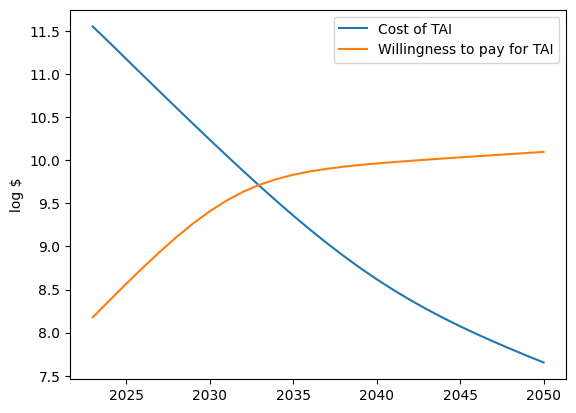

-
-
## SAMPLE RUN 8 ##
It takes 25.8 log FLOP (~63 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.0 log FLOP (~921 quadrillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~14 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 2.5 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.5 max log FLOP (322 septillion) available - TAI takes 25.8 log FLOP (63 septillion) - log $ 7.8 to buy TAI (69 million) vs. willingness to pay log $ 8.5 (350 million) - 18.0 log FLOP per $ (921 quadrillion) (Effective 2023-logFLOP: 26.5)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 16 years (total delay 16 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (to

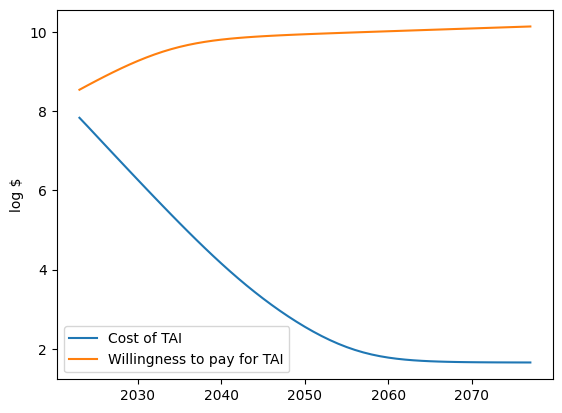

-
-
## SAMPLE RUN 9 ##
It takes 30.4 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~18 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~20 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~494 million). This doubles every 3.2 years to a max of 0.144838% of GDP (initially ~33 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.9 max log FLOP (9 octillion) available - TAI takes 30.4 log FLOP (3 nonillion) - log $ 11.2 to buy TAI (144 billion) vs. willingness to pay log $ 8.7 (487 million) - 19.2 log FLOP per $ (17 quintillion) (Effective 2023-logFLOP: 27.9)
Year: 2024 - 28.2 max log FLOP (15 octillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 10.9 to buy TAI (79 billion) vs. willingness to pay log $ 8.8 (602 million) - 19.4 log FLOP per $ (24 quintil

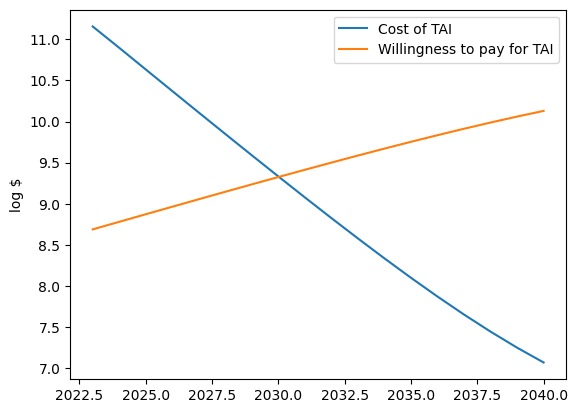

-
-
## SAMPLE RUN 10 ##
It takes 27.4 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~268 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 5.5 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.034x per year.
---
Year: 2023 - 26.6 max log FLOP (441 septillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.5 (350 million) - 18.1 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (632 septillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.6 (394 million) - 18.2 log FLOP per $ (2 quintillion) (

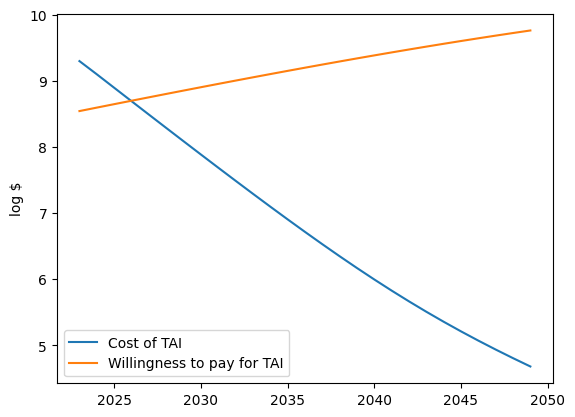

-
-
## SAMPLE RUN 11 ##
It takes 27.0 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~9 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~496 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.194307% of GDP (initially ~45 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.5 to buy TAI (295 million) vs. willingness to pay log $ 8.7 (490 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay oc

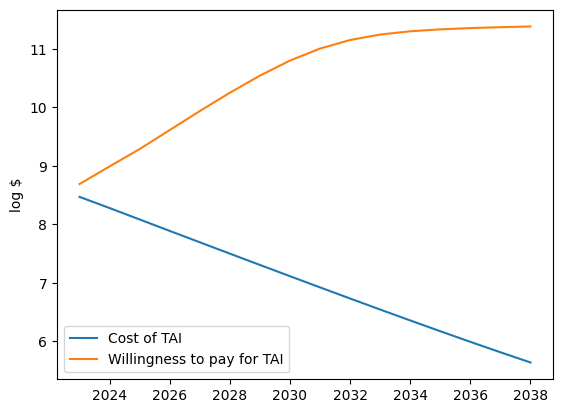

-
-
## SAMPLE RUN 12 ##
It takes 38.7 log FLOP (~501 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 20.6 log FLOP (~436 quintillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~607 million). This doubles every 17.6 years to a max of 0.070544% of GDP (initially ~16 billion 2022$USD). GDP grows at a rate of 1.034x per year.
---
Year: 2023 - 27.0 max log FLOP (939 septillion) available - TAI takes 38.7 log FLOP (501 thousand decillion) - log $ 20.5 to buy TAI (312 quintillion) vs. willingness to pay log $ 8.8 (585 million) - 18.2 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 38.4 log FLOP (251 thousand decillion) - log $ 20.1 to buy TAI (119 quintillion) vs. willingness to pay log $ 8.8 (60

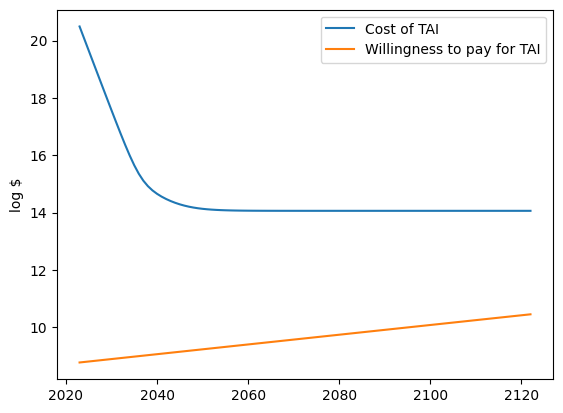

-
-
## SAMPLE RUN 13 ##
It takes 26.6 log FLOP (~398 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~16 septillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~199 million). This doubles every 3.8 years to a max of 0.306941% of GDP (initially ~71 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.9 max log FLOP (721 septillion) available - TAI takes 26.6 log FLOP (398 septillion) - log $ 8.0 to buy TAI (110 million) vs. willingness to pay log $ 8.3 (198 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_is

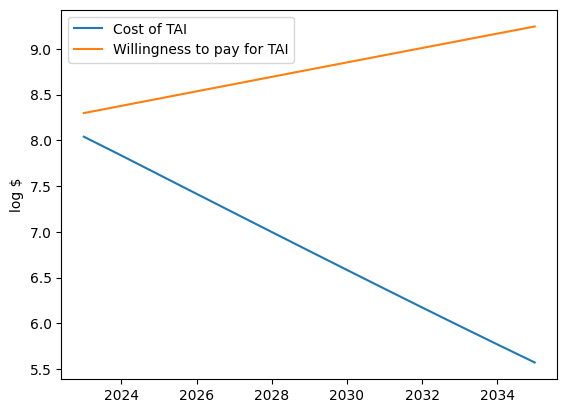

-
-
## SAMPLE RUN 14 ##
It takes 31.4 log FLOP (~25 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~898 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~714 million). This doubles every 5.8 years to a max of 0.03067% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 27.0 max log FLOP (975 septillion) available - TAI takes 31.4 log FLOP (25 nonillion) - log $ 13.2 to buy TAI (17 trillion) vs. willingness to pay log $ 8.8 (648 million) - 18.2 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 31.3 log FLOP (19 nonillion) - log $ 13.0 to buy TAI (9 trillion) vs. willingness to pay log $ 8.9 (724 million) - 18.3 log FLOP per $ (2 quint

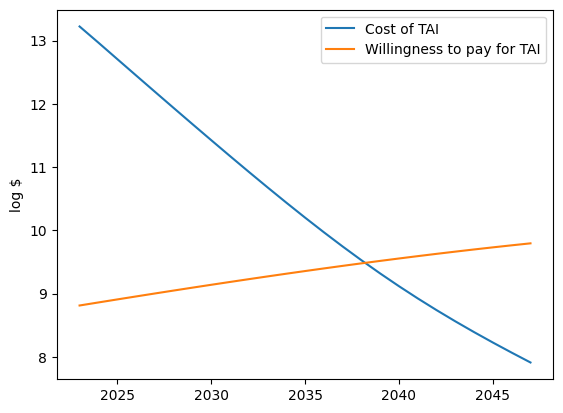

-
-
## SAMPLE RUN 15 ##
It takes 45.2 log FLOP (~2 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4.4 log reductions possible.
FLOP start at a cost of 18.0 log FLOP (~1 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~32 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 9.7 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.6 max log FLOP (363 septillion) available - TAI takes 45.2 log FLOP (2 trillion decillion) - log $ 27.2 to buy TAI (2 octillion) vs. willingness to pay log $ 8.5 (350 million) - 18.0 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (587 septillion) available - TAI takes 44.9 log FLOP (793 billion decillion) - log $ 26.7 to buy TAI (506 septillion) vs. willingness to pay log $ 8.6 (375 million) -

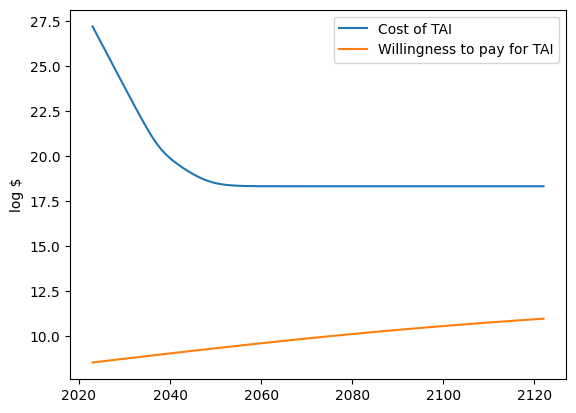

-
-
## SAMPLE RUN 16 ##
It takes 32.7 log FLOP (~501 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~311 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 1.0 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.8 max log FLOP (681 septillion) available - TAI takes 32.7 log FLOP (501 nonillion) - log $ 14.5 to buy TAI (314 trillion) vs. willingness to pay log $ 8.6 (427 million) - 18.2 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 32.6 log FLOP (359 nonillion) - log $ 14.2 to buy TAI (161 trillion) vs. willingness to pay log $ 8.9 (779 million) - 18.3 log FLOP per $ (2 q

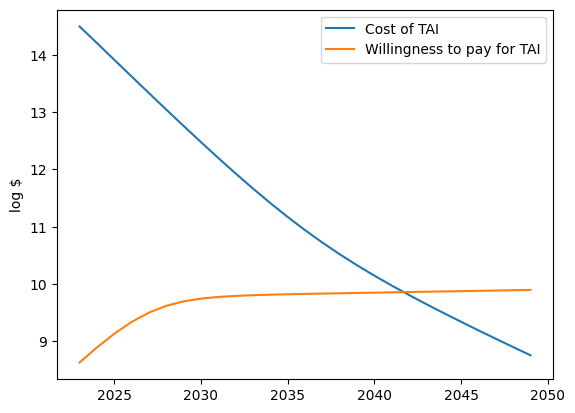

-
-
## SAMPLE RUN 17 ##
It takes 38.2 log FLOP (~158 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~21 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~304 million). This doubles every 1.3 years to a max of 0.034708% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.9 max log FLOP (835 septillion) available - TAI takes 38.2 log FLOP (158 thousand decillion) - log $ 19.7 to buy TAI (56 quintillion) vs. willingness to pay log $ 8.5 (293 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 37.9 log FLOP (79 thousand decillion) - log $ 19.3 to buy TAI (20 quintillion) vs. willingness to pay log $ 8.7 (495 milli

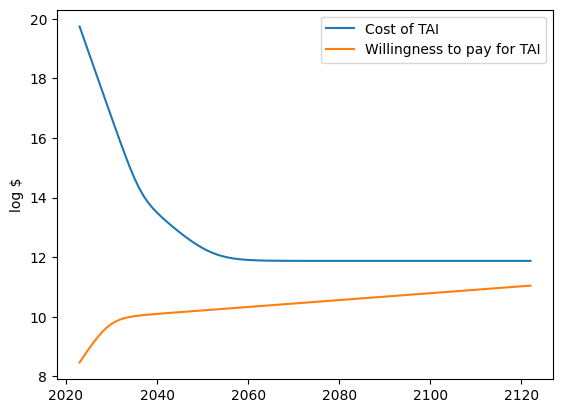

-
-
## SAMPLE RUN 18 ##
It takes 29.0 log FLOP (~100 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~48 septillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 8.0 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.7 max log FLOP (5 octillion) available - TAI takes 29.0 log FLOP (100 octillion) - log $ 10.1 to buy TAI (13 billion) vs. willingness to pay log $ 8.8 (622 million) - 18.9 log FLOP per $ (8 quintillion) (Effective 2023-logFLOP: 27.7)
Year: 2024 - 27.9 max log FLOP (7 octillion) available - TAI takes 28.9 log FLOP (80 octillion) - log $ 9.9 to buy TAI (8 billion) vs. willingness to pay log $ 8.8 (674 million) - 19.0 log FLOP per $ (11 quintillion)

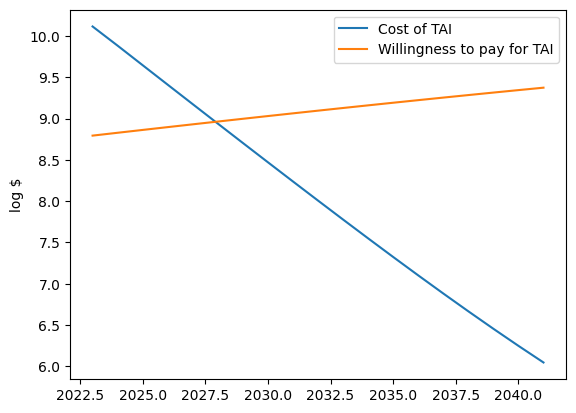

-
-
## SAMPLE RUN 19 ##
It takes 25.3 log FLOP (~20 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~69 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~622 million). This doubles every 1.4 years to a max of 0.187841% of GDP (initially ~43 billion 2022$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 25.3 log FLOP (20 septillion) - log $ 6.8 to buy TAI (6 million) vs. willingness to pay log $ 8.8 (613 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.3)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.

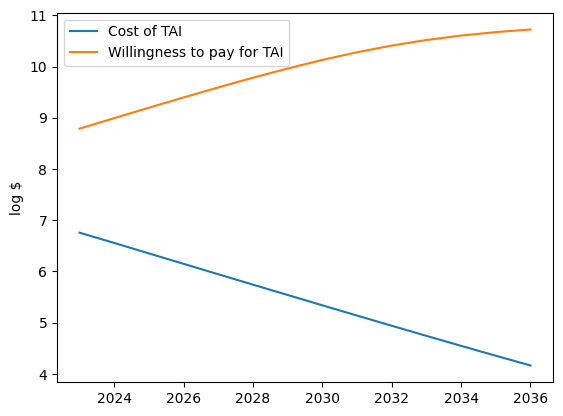

-
-
## SAMPLE RUN 20 ##
It takes 27.2 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~6 quintillion) per 2022$USD. Every 1.3 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~492 million). This doubles every 4.0 years to a max of 0.113396% of GDP (initially ~26 billion 2022$USD). GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.5 to buy TAI (285 million) vs. willingness to pay log $ 8.7 (483 million) - 18.7 log FLOP per $ (6 quintillion) (Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.0 

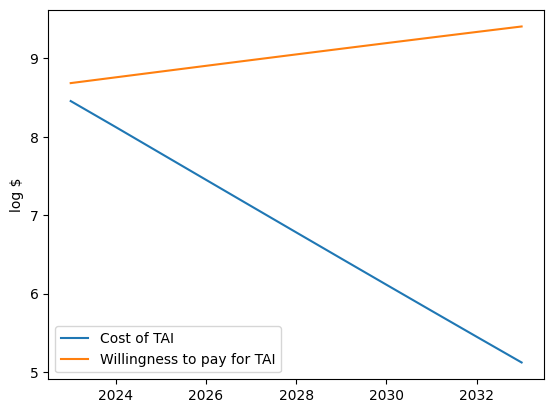

-
-
## SAMPLE RUN 21 ##
It takes 29.2 log FLOP (~158 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~6 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~35 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~884 million). This doubles every 1.8 years to a max of 0.032987% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.005x per year.
---
Year: 2023 - 27.7 max log FLOP (5 octillion) available - TAI takes 29.2 log FLOP (158 octillion) - log $ 10.4 to buy TAI (27 billion) vs. willingness to pay log $ 8.9 (791 million) - 18.8 log FLOP per $ (6 quintillion) (Effective 2023-logFLOP: 27.7)
Year: 2024 - 27.9 max log FLOP (8 octillion) available - TAI takes 29.1 log FLOP (127 octillion) - log $ 10.2 to buy TAI (17 billion) vs. willingness to pay log $ 9.0 (1 billion) - 18.9 log FLOP per $ (7 quintill

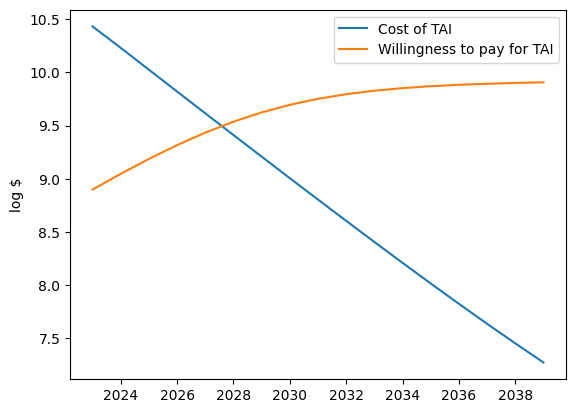

-
-
## SAMPLE RUN 22 ##
It takes 28.5 log FLOP (~32 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~17 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~26 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~852 million). This doubles every 1.6 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.006x per year.
---
Year: 2023 - 28.1 max log FLOP (13 octillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.9 (742 million) - 19.2 log FLOP per $ (17 quintillion) (Effective 2023-logFLOP: 28.1)
Year: 2024 - 28.4 max log FLOP (24 octillion) available - TAI takes 28.4 log FLOP (25 octillion) - log $ 9.0 to buy TAI (1 billion) vs. willingness to pay log $ 9.0 (1 billion) - 19.4 log FLOP per $ (23 quintillion) 

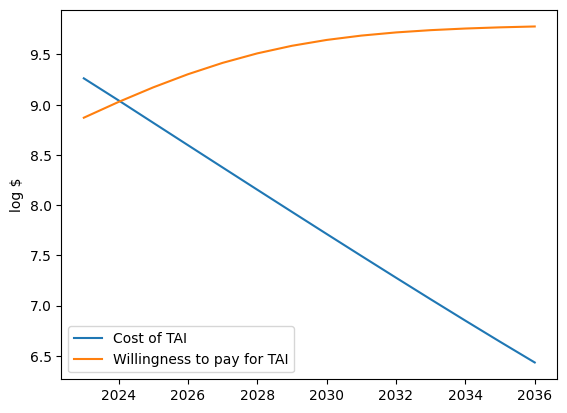

-
-
## SAMPLE RUN 23 ##
It takes 29.4 log FLOP (~251 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~474 million). This doubles every 3.7 years to a max of 0.037518% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.9 max log FLOP (823 septillion) available - TAI takes 29.4 log FLOP (251 octillion) - log $ 11.1 to buy TAI (137 billion) vs. willingness to pay log $ 8.7 (449 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.3 log FLOP (202 octillion) - log $ 10.9 to buy TAI (88 billion) vs. willingness to pay log $ 8.7 (536 million) - 18.4 log FLOP per $ (2 qui

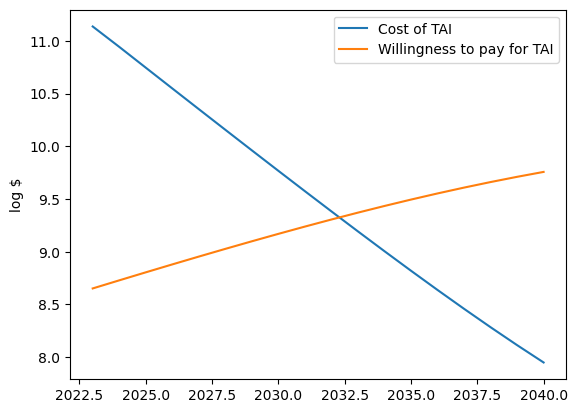

-
-
## SAMPLE RUN 24 ##
It takes 35.4 log FLOP (~251 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~741 million). This doubles every 2.2 years to a max of 0.04839% of GDP (initially ~11 billion 2022$USD). GDP grows at a rate of 1.009x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 35.4 log FLOP (251 decillion) - log $ 16.8 to buy TAI (57 quadrillion) vs. willingness to pay log $ 8.8 (695 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 35.2 log FLOP (158 decillion) - log $ 16.5 to buy TAI (29 quadrillion) vs. willingness to pay log $ 9.0 (934 million) - 18.7 log FLOP per $ (5

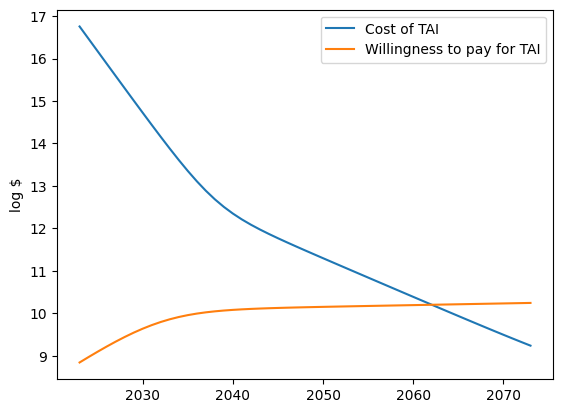

-
-
## SAMPLE RUN 25 ##
It takes 25.2 log FLOP (~16 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~41 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~728 million). This doubles every 2.5 years to a max of 0.037902% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 25.2 log FLOP (16 septillion) - log $ 6.6 to buy TAI (4 million) vs. willingness to pay log $ 8.8 (672 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total de

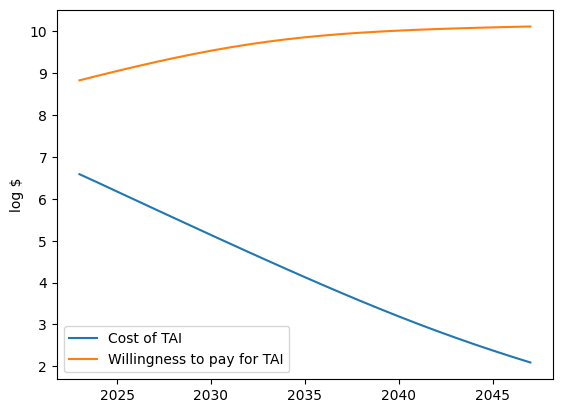

-
-
## SAMPLE RUN 26 ##
It takes 39.2 log FLOP (~2 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 1.6 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~722 million). This doubles every 1.2 years to a max of 0.034326% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 39.2 log FLOP (2 million decillion) - log $ 20.5 to buy TAI (308 quintillion) vs. willingness to pay log $ 8.8 (661 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.9 max log FLOP (9 octillion) available - TAI takes 38.9 log FLOP (793 thousand decillion) - log $ 20.0 to buy TAI (101 quintillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.

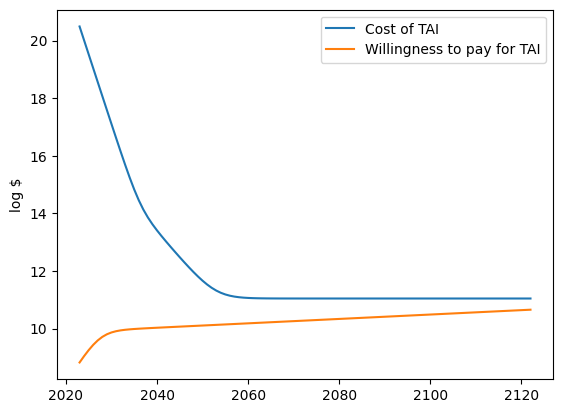

-
-
## SAMPLE RUN 27 ##
It takes 32.3 log FLOP (~200 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~12 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~106 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~306 million). This doubles every 3.4 years to a max of 0.042012% of GDP (initially ~10 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 27.5 max log FLOP (4 octillion) available - TAI takes 32.3 log FLOP (200 nonillion) - log $ 13.2 to buy TAI (17 trillion) vs. willingness to pay log $ 8.5 (297 million) - 19.1 log FLOP per $ (12 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 32.2 log FLOP (143 nonillion) - log $ 12.9 to buy TAI (9 trillion) vs. willingness to pay log $ 8.6 (363 million) - 19.2 log FLOP per $ (17 

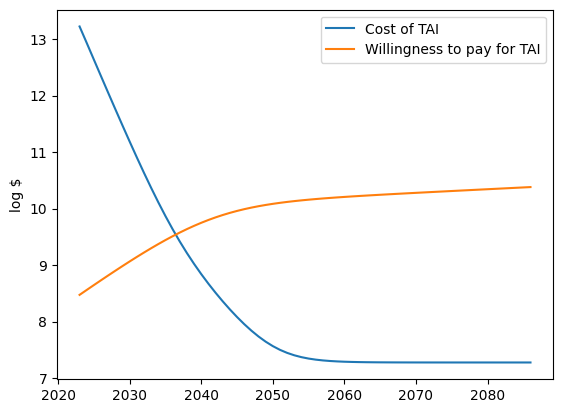

-
-
## SAMPLE RUN 28 ##
It takes 35.7 log FLOP (~501 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~10 quintillion) per 2022$USD. Every 5.5 years they get 2x cheaper, to a maximum of 27.0 log FLOP (~1 octillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~763 million). This doubles every 13.0 years to a max of 0.084012% of GDP (initially ~19 billion 2022$USD). GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 27.9 max log FLOP (8 octillion) available - TAI takes 35.7 log FLOP (501 decillion) - log $ 16.7 to buy TAI (48 quadrillion) vs. willingness to pay log $ 8.9 (734 million) - 19.0 log FLOP per $ (10 quintillion) (Effective 2023-logFLOP: 27.9)
Year: 2024 - 28.0 max log FLOP (9 octillion) available - TAI takes 35.5 log FLOP (316 decillion) - log $ 16.4 to buy TAI (27 quadrillion) vs. willingness to pay log $ 8.9 (773 million) - 19.1 log FLOP per $

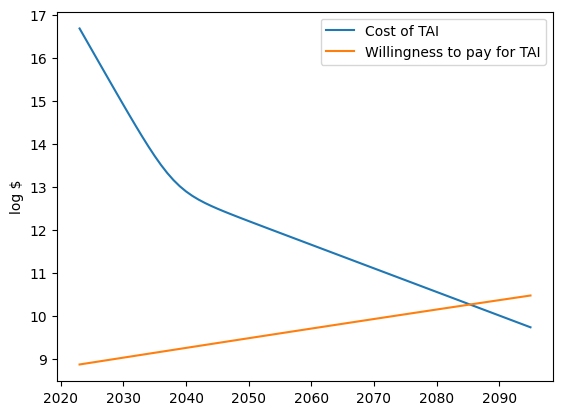

-
-
## SAMPLE RUN 29 ##
It takes 30.1 log FLOP (~1 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 27.2 log FLOP (~2 octillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~387 million). This doubles every 1.3 years to a max of 0.061978% of GDP (initially ~14 billion 2022$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 30.1 log FLOP (1 nonillion) - log $ 11.6 to buy TAI (443 billion) vs. willingness to pay log $ 8.6 (377 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 30.0 log FLOP (967 octillion) - log $ 11.4 to buy TAI (250 billion) vs. willingness to pay log $ 8.8 (642 million) - 18.6 log FLOP per $ (4 quintilli

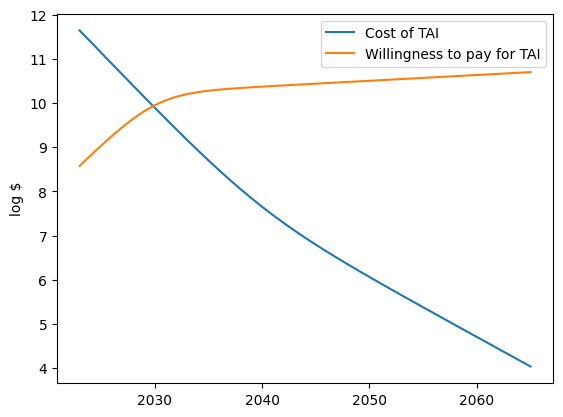

-
-
## SAMPLE RUN 30 ##
It takes 28.9 log FLOP (~79 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2022$USD. Every 4.5 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~101 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~389 million). This doubles every 1.0 years to a max of 0.071487% of GDP (initially ~16 billion 2022$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.0 max log FLOP (950 septillion) available - TAI takes 28.9 log FLOP (79 octillion) - log $ 10.5 to buy TAI (32 billion) vs. willingness to pay log $ 8.6 (380 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 28.8 log FLOP (64 octillion) - log $ 10.3 to buy TAI (22 billion) vs. willingness to pay log $ 8.9 (729 million) - 18.5 log FLOP per $ (3 quin

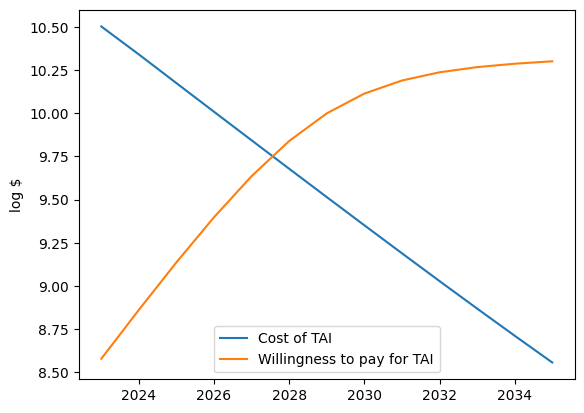

-
-
## SAMPLE RUN 31 ##
It takes 26.5 log FLOP (~316 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~7 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~852 million). This doubles every 2.1 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 27.0 max log FLOP (987 septillion) available - TAI takes 26.5 log FLOP (316 septillion) - log $ 8.4 to buy TAI (238 million) vs. willingness to pay log $ 8.9 (742 million) - 18.1 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p

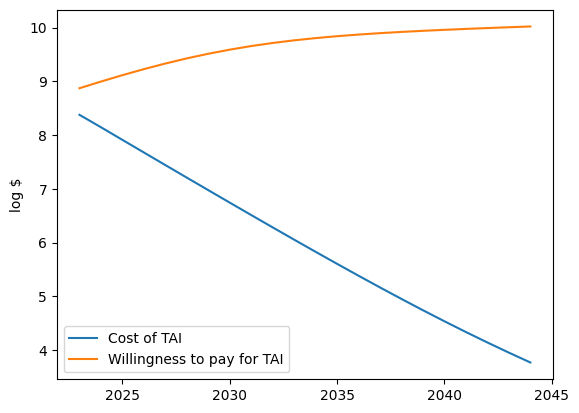

-
-
## SAMPLE RUN 32 ##
It takes 26.1 log FLOP (~126 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 17.9 log FLOP (~721 quadrillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~15 septillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~158 million). This doubles every 5.6 years to a max of 0.115929% of GDP (initially ~27 billion 2022$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.1 max log FLOP (113 septillion) available - TAI takes 26.1 log FLOP (126 septillion) - log $ 8.2 to buy TAI (175 million) vs. willingness to pay log $ 8.2 (157 million) - 17.9 log FLOP per $ (721 quadrillion) (Effective 2023-logFLOP: 26.1)
Year: 2024 - 26.2 max log FLOP (175 septillion) available - TAI takes 26.0 log FLOP (101 septillion) - log $ 8.0 to buy TAI (102 million) vs. willingness to pay log $ 8.2 (177 million) - 18.0 log FLOP per

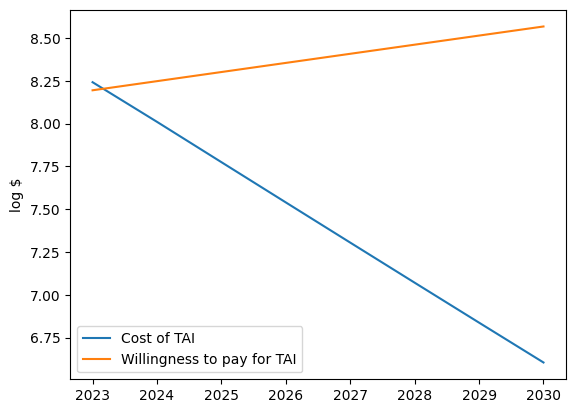

-
-
## SAMPLE RUN 33 ##
It takes 36.8 log FLOP (~6 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~9 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~396 million). This doubles every 3.5 years to a max of 0.37588% of GDP (initially ~86 billion 2022$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 36.8 log FLOP (6 thousand decillion) - log $ 17.8 to buy TAI (691 quadrillion) vs. willingness to pay log $ 8.6 (394 million) - 19.0 log FLOP per $ (9 quintillion) (Effective 2023-logFLOP: 27.6)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 36.5 log FLOP (3 thousand decillion) - log $ 17.4 to buy TAI (269 quadrillion) vs. willingness to pay log $ 8.7 (481 million) -

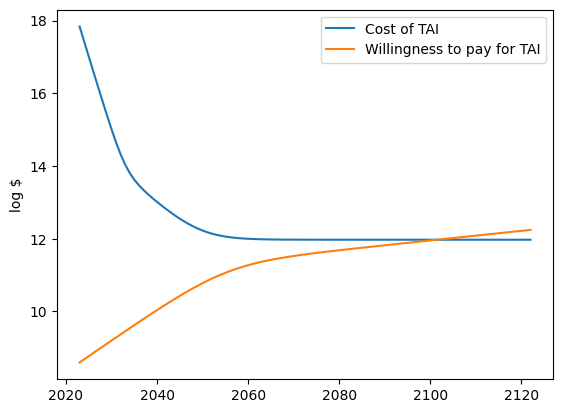

-
-
## SAMPLE RUN 34 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 9.0 years to a max of 0.025331% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.5 max log FLOP (299 septillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.7 to buy TAI (496 million) vs. willingness to pay log $ 8.3 (187 million) - 18.2 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.6 max log FLOP (403 septillion) available - TAI takes 26.8 log FLOP (638 septillion) - log $ 8.5 to buy TAI (319 million) vs. willingness to pay log $ 8.3 (201 million) - 18.3 log FLOP per $ (2 

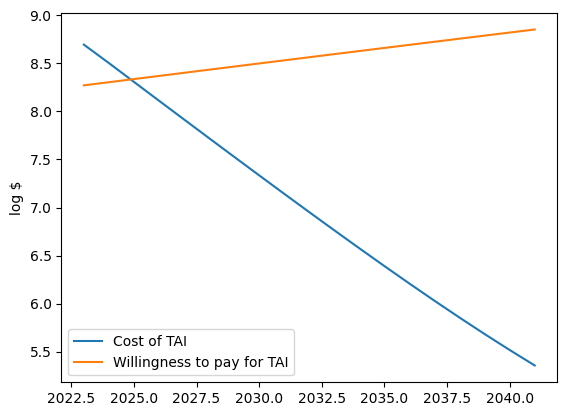

-
-
## SAMPLE RUN 35 ##
It takes 29.7 log FLOP (~501 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.3 log FLOP (~18 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~10 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 3.8 years to a max of 0.025689% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.035x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 29.7 log FLOP (501 octillion) - log $ 10.4 to buy TAI (28 billion) vs. willingness to pay log $ 8.4 (232 million) - 19.3 log FLOP per $ (18 quintillion) (Effective 2023-logFLOP: 27.6)
Year: 2024 - 27.9 max log FLOP (7 octillion) available - TAI takes 29.6 log FLOP (403 octillion) - log $ 10.2 to buy TAI (16 billion) vs. willingness to pay log $ 8.4 (276 million) - 19.4 log FLOP per $ (26 qui

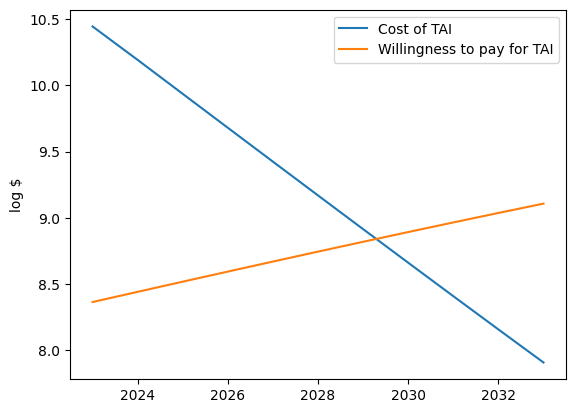

-
-
## SAMPLE RUN 36 ##
It takes 28.2 log FLOP (~16 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~7 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~65 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 2.2 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 9.4 to buy TAI (2 billion) vs. willingness to pay log $ 8.6 (427 million) - 18.8 log FLOP per $ (7 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.8 (574 million) - 19.0 log FLOP per $ (10 quintillion) (E

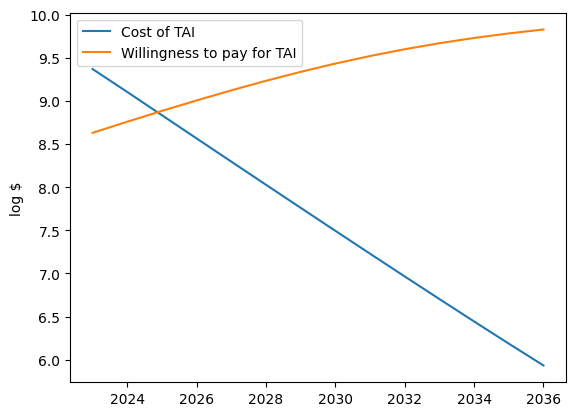

-
-
## SAMPLE RUN 37 ##
It takes 26.1 log FLOP (~126 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2 quintillion) per 2022$USD. Every 1.3 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~676 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~852 million). This doubles every 4.2 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 26.1 log FLOP (126 septillion) - log $ 7.7 to buy TAI (51 million) vs. willingness to pay log $ 8.9 (742 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.

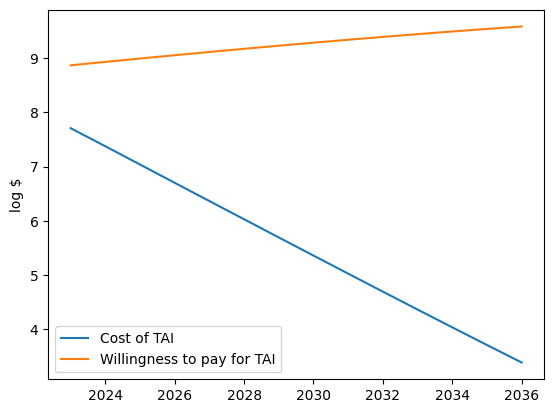

-
-
## SAMPLE RUN 38 ##
It takes 29.2 log FLOP (~158 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 1.5 years to a max of 0.036804% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 29.2 log FLOP (158 octillion) - log $ 11.0 to buy TAI (100 billion) vs. willingness to pay log $ 9.1 (1 billion) - 18.2 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 29.1 log FLOP (127 octillion) - log $ 10.7 to buy TAI (53 billion) vs. willingness to pay log $ 9.3 (2 billion) - 18.4 log FLOP per $ (2 quintillion)

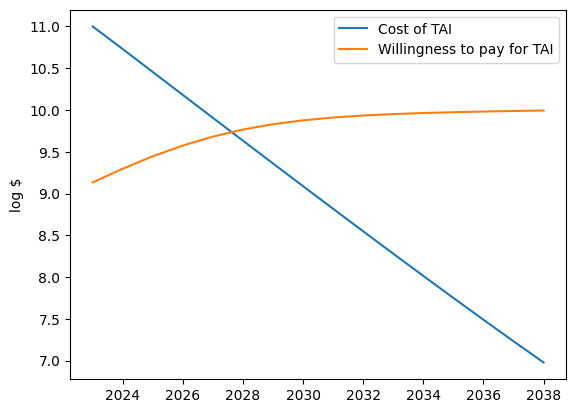

-
-
## SAMPLE RUN 39 ##
It takes 29.1 log FLOP (~126 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~8 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~397 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.554237% of GDP (initially ~127 billion 2022$USD). GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 29.1 log FLOP (126 octillion) - log $ 10.7 to buy TAI (48 billion) vs. willingness to pay log $ 8.6 (396 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 29.0 log FLOP (101 octillion) - log $ 10.5 to buy TAI (32 billion) vs. willingness to pay log $ 8.9

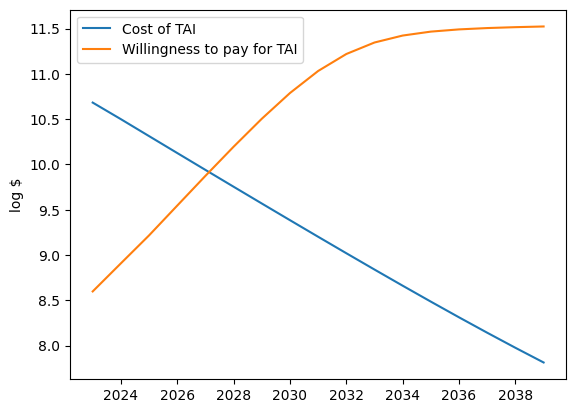

-
-
## SAMPLE RUN 40 ##
It takes 27.0 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~153 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~377 million). This doubles every 4.3 years to a max of 0.031053% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.5 to buy TAI (334 million) vs. willingness to pay log $ 8.6 (358 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.0

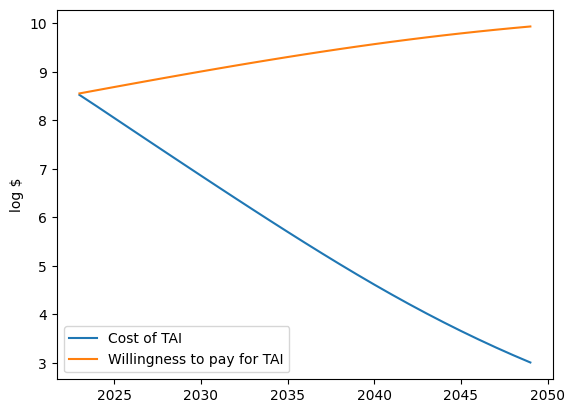

-
-
## SAMPLE RUN 41 ##
It takes 32.4 log FLOP (~251 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~9 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~379 million). This doubles every 3.5 years to a max of 0.035214% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 32.4 log FLOP (251 nonillion) - log $ 13.4 to buy TAI (28 trillion) vs. willingness to pay log $ 8.6 (362 million) - 19.0 log FLOP per $ (9 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 32.3 log FLOP (180 nonillion) - log $ 13.2 to buy TAI (14 trillion) vs. willingness to pay log $ 8.6 (437 million) - 19.1 log FLOP per $ (12 quin

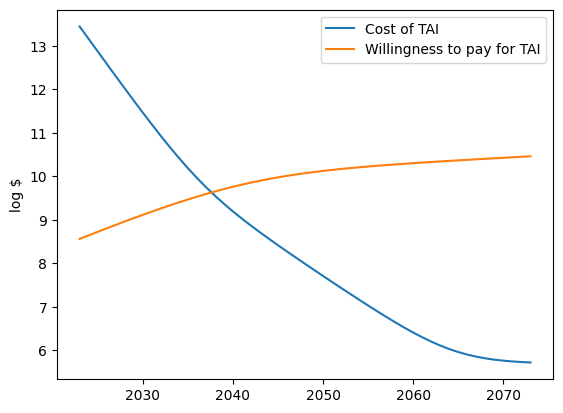

-
-
## SAMPLE RUN 42 ##
It takes 25.1 log FLOP (~13 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~36 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~243 million). This doubles every 5.2 years to a max of 0.032677% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 25.1 log FLOP (13 septillion) - log $ 6.4 to buy TAI (2 million) vs. willingness to pay log $ 8.4 (235 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 12 years (total delay 12 years)
-- data p_nonscaling_issue p=

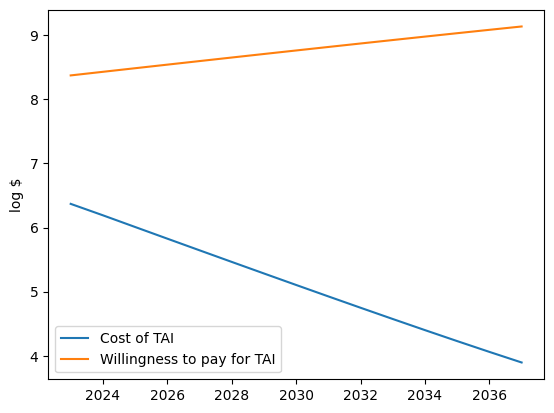

-
-
## SAMPLE RUN 43 ##
It takes 26.6 log FLOP (~398 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~12 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~43 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~305 million). This doubles every 3.6 years to a max of 0.038048% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 26.6 log FLOP (398 septillion) - log $ 7.5 to buy TAI (34 million) vs. willingness to pay log $ 8.5 (295 million) - 19.1 log FLOP per $ (12 quintillion) (Effective 2023-logFLOP: 27.5)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue

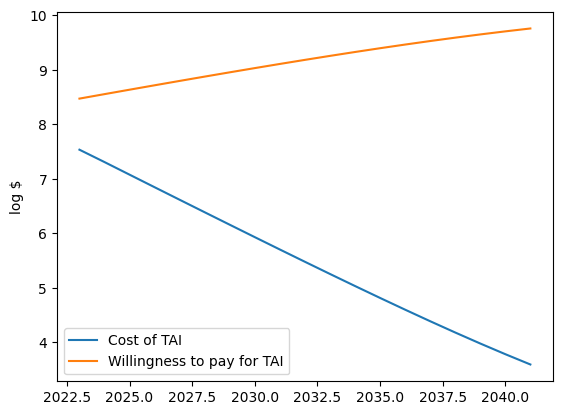

-
-
## SAMPLE RUN 44 ##
It takes 27.0 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 1.1 years to a max of 0.029176% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 27.9 max log FLOP (7 octillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.1 to buy TAI (127 million) vs. willingness to pay log $ 9.0 (915 million) - 18.9 log FLOP per $ (8 quintillion) (Effective 2023-logFLOP: 27.9)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4

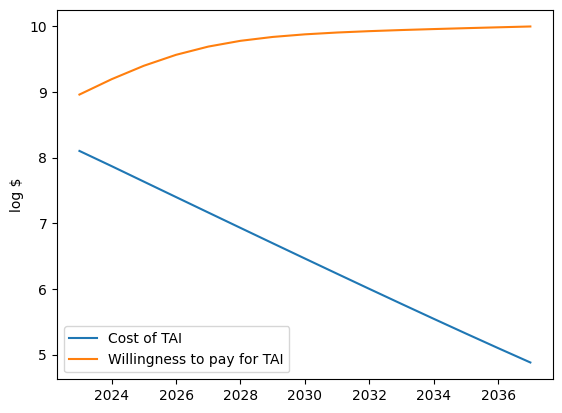

-
-
## SAMPLE RUN 45 ##
It takes 36.4 log FLOP (~3 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 26.0 log FLOP (~99 septillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~598 million). This doubles every 4.3 years to a max of 0.049608% of GDP (initially ~11 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 36.4 log FLOP (3 thousand decillion) - log $ 17.7 to buy TAI (468 quadrillion) vs. willingness to pay log $ 8.8 (568 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 36.1 log FLOP (1 thousand decillion) - log $ 17.2 to buy TAI (160 quadrillion) vs. willingness to pay log $ 8.8 (661 million)

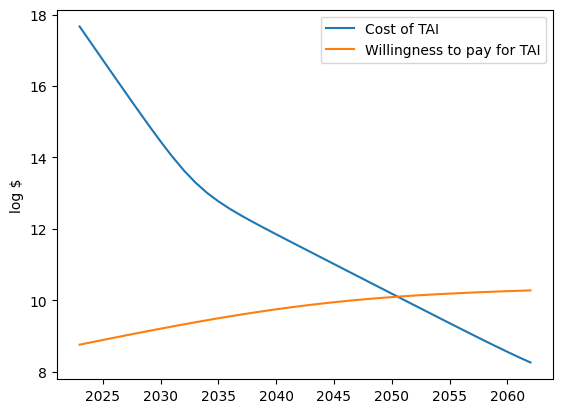

-
-
## SAMPLE RUN 46 ##
It takes 30.4 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.4 log FLOP (~26 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3 septillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 2.9 years to a max of 0.10719% of GDP (initially ~25 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 30.4 log FLOP (3 nonillion) - log $ 11.0 to buy TAI (98 billion) vs. willingness to pay log $ 8.1 (125 million) - 19.4 log FLOP per $ (26 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 10.8 to buy TAI (57 billion) vs. willingness to pay log $ 8.2 (158 million) - 19.5 log FLOP per $ (34 quintillio

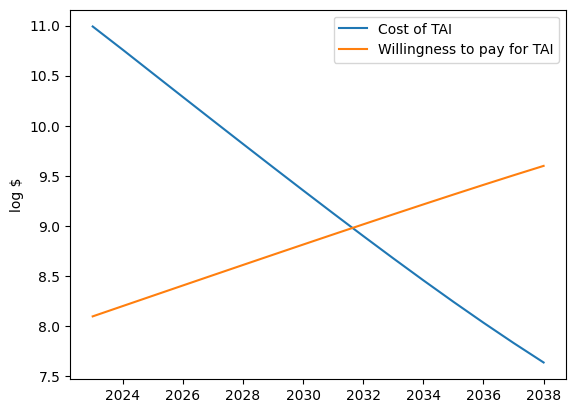

-
-
## SAMPLE RUN 47 ##
It takes 28.3 log FLOP (~20 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~10 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 1.3 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 28.3 log FLOP (20 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.5 (285 million) - 19.0 log FLOP per $ (10 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.7 (479 million) - 19.1 log FLOP per $ (14 quintillion) (

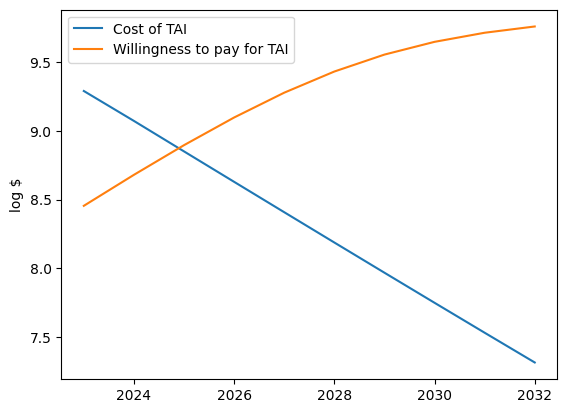

-
-
## SAMPLE RUN 48 ##
It takes 32.5 log FLOP (~316 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 4.9 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 1.7 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 32.5 log FLOP (316 nonillion) - log $ 13.8 to buy TAI (63 trillion) vs. willingness to pay log $ 8.4 (231 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 32.4 log FLOP (227 nonillion) - log $ 13.6 to buy TAI (39 trillion) vs. willingness to pay log $ 8.5 (341 million) - 18.8 log FLOP per $ (6 quintil

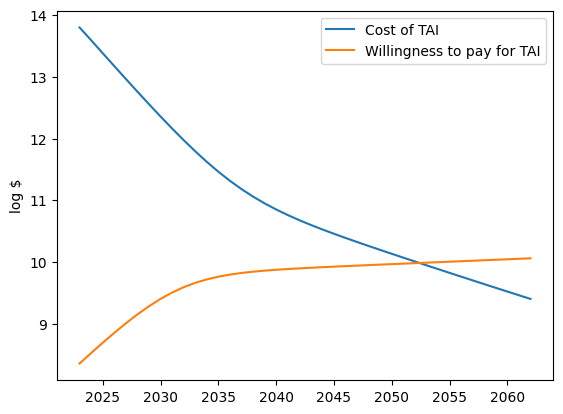

-
-
## SAMPLE RUN 49 ##
It takes 33.9 log FLOP (~8 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~11 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 2.4 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 33.9 log FLOP (8 decillion) - log $ 15.3 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.6 (427 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 33.8 log FLOP (6 decillion) - log $ 15.0 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.7 (558 million) - 18.7 log FLOP per $ (5 quintilli

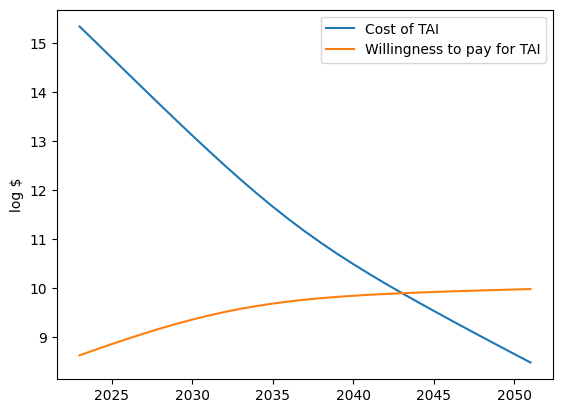

-
-
## SAMPLE RUN 50 ##
It takes 31.0 log FLOP (~10 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~297 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~306 million). This doubles every 3.3 years to a max of 0.039699% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 31.0 log FLOP (10 nonillion) - log $ 12.5 to buy TAI (3 trillion) vs. willingness to pay log $ 8.5 (296 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 30.9 log FLOP (8 nonillion) - log $ 12.3 to buy TAI (2 trillion) vs. willingness to pay log $ 8.6 (362 million) - 18.6 log FLOP per $ (4 quintilli

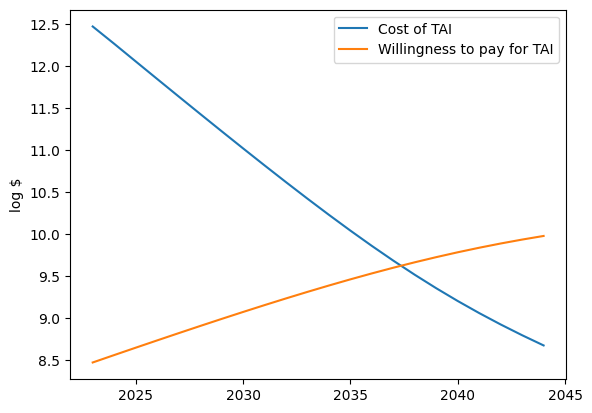

-
-
## SAMPLE RUN 51 ##
It takes 33.7 log FLOP (~5 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~6 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~377 million). This doubles every 2.7 years to a max of 0.030876% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 33.7 log FLOP (5 decillion) - log $ 14.9 to buy TAI (880 trillion) vs. willingness to pay log $ 8.6 (358 million) - 18.8 log FLOP per $ (6 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 33.6 log FLOP (4 decillion) - log $ 14.7 to buy TAI (486 trillion) vs. willingness to pay log $ 8.7 (457 million) - 18.9 log FLOP per $ (7 quintilli

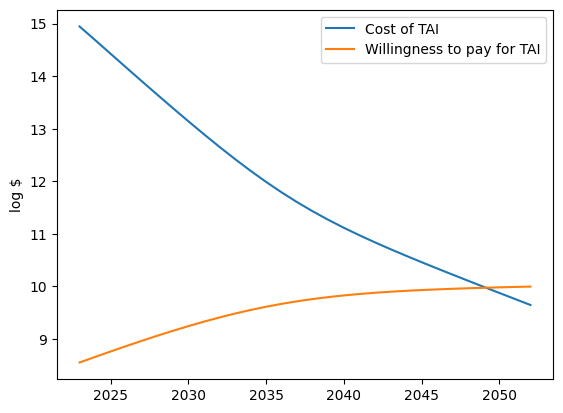

-
-
## SAMPLE RUN 52 ##
It takes 35.3 log FLOP (~200 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~9 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 25.9 log FLOP (~71 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~250 million). This doubles every 2.2 years to a max of 0.306915% of GDP (initially ~71 billion 2022$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.4 max log FLOP (2 octillion) available - TAI takes 35.3 log FLOP (200 decillion) - log $ 16.3 to buy TAI (21 quadrillion) vs. willingness to pay log $ 8.4 (249 million) - 19.0 log FLOP per $ (9 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 35.1 log FLOP (126 decillion) - log $ 16.0 to buy TAI (11 quadrillion) vs. willingness to pay log $ 8.5 (343 million) - 19.1 log FLOP per $ 

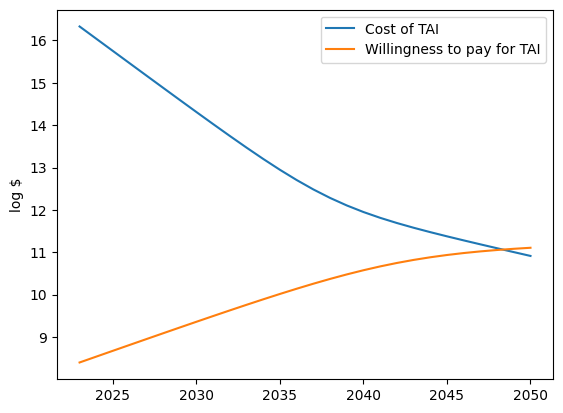

-
-
## SAMPLE RUN 53 ##
It takes 25.6 log FLOP (~40 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.3 log FLOP (~18 quintillion) per 2022$USD. Every 1.5 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~382 million). This doubles every 1.3 years to a max of 0.040479% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 27.8 max log FLOP (7 octillion) available - TAI takes 25.6 log FLOP (40 septillion) - log $ 6.3 to buy TAI (2 million) vs. willingness to pay log $ 8.6 (367 million) - 19.3 log FLOP per $ (18 quintillion) (Effective 2023-logFLOP: 27.8)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0

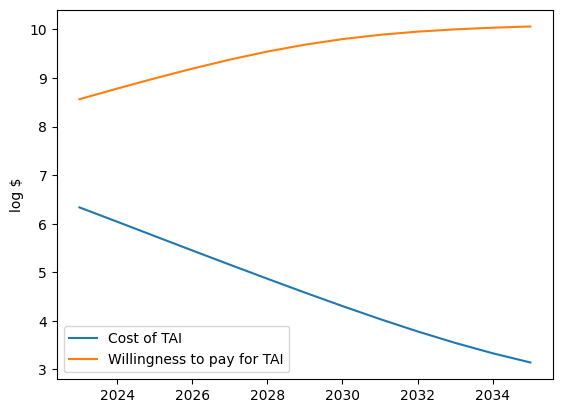

In [10]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [11]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2023-09-08 13:41:06.388554
